# Дипломная работа "Анализ эмоциальной окраски текста"

### Ячейка для Kaggle Kernel

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


## Задача 1 "Hate Speech and Offensive Language Dataset - research hate-speech detection"

Набор данных с использованием данных Twitter использовался для исследования обнаружения языка ненависти. Текст классифицируется как: разжигание ненависти, оскорбительные выражения и ни то, ни другое. В связи с характером исследования важно отметить, что этот набор данных содержит текст, который можно считать расистским, сексистским, гомофобным или вообще оскорбительным.


- count - количество пользователей CrowdFlower, которые закодировали каждый твит (минимум 3, иногда больше пользователей закодировали твит, когда CF определило суждения как ненадежные)
- hate_speech - количество пользователей CF, которые оценили твит как разжигание ненависти
- offensive_language	- количество пользователей CF, которые сочли твит оскорбительным
- neither	 - количество пользователей CF, которые сочли твит ни оскорбительным, ни не оскорбительным
- class(target) - метка класса для большинства пользователей CF. 
- - 0 – разжигание ненависти 
- - 1 – оскорбительные выражения 
- - 2 – ни то, ни другое
- tweet - текстовый твит

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import re
import string 
from string import punctuation
from nltk.corpus import stopwords
print(stopwords.words('english'))
NOISE_WORDS = stopwords.words('english')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
import spacy
LEMMA = spacy.load('en_core_web_sm')

In [2]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.svm import SVC

from nltk import word_tokenize

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

### Загрузка данных (с нуля - далее по коду есть файл с обработанными данными название df_2_task_1.csv, чтобы не ждать выполнения функции clean_text)

In [22]:
#../input/hate-speech-and-offensive-language-dataset/labeled_data.csv
df_1 = pd.read_csv('C:/Netology/DIPLOMA/data/hate/labeled_data.csv', index_col='Unnamed: 0')

### Анализ данных

In [8]:
df_1.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df_1[df_1.hate_speech == 1]

,count,hate_speech,offensive_language,neither,class,tweet
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."
14,3,1,2,0,1,""" bitch get up off me """
17,3,1,2,0,1,""" bitch who do you love """
49,3,1,2,0,1,""" these hoes like niggas that spend money not ..."
...,...,...,...,...,...,...
25262,3,1,2,0,1,yo hoe will get slayed! &#128298;
25265,6,1,5,0,1,you ain't a real nigga without goal a to chase...
25266,3,1,2,0,1,you ain't gotta be a dyke to like hoes
25275,3,1,2,0,1,"you got niggas, and i got bitches."


In [10]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


### Распределение количества данных по классам

In [11]:
df_1[['class', 'tweet']].groupby('class').count()

,tweet
class,
0,1430
1,19190
2,4163


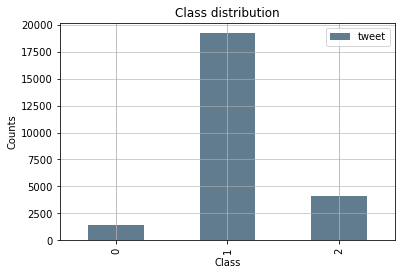

In [12]:
plot_1 = df_1[['class', 'tweet']].groupby('class').count()

plot_1.plot(kind='bar', grid = True,
                   color='#607c8e')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

###### Видно, что преобладают данные класса 1 - с оскорбительными выражениями


### Распределение по количеству пользователей CF, которые отнесли твит к тому или иному классу

In [13]:
df_1.groupby(['class']).sum()

,count,hate_speech,offensive_language,neither
class,,,,
0,4445,3227,1081,137
1,62730,3463,57638,1629
2,13208,262,1100,11846


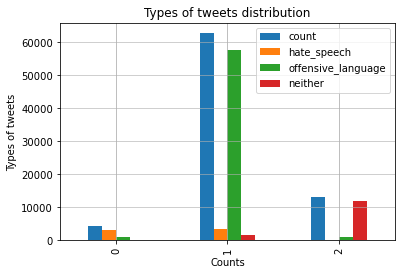

In [14]:
plot_2 = df_1.groupby(['class']).sum()

plot_2.plot(kind='bar', grid = True)
plt.title('Types of tweets distribution')
plt.xlabel('Counts')
plt.ylabel('Types of tweets')
plt.grid(axis='y', alpha=0.75)

###### Видно, что пользователи однозначно относят к верному классу твит, но в основном большинство на одной стороне

### Предобработка текста твитов

In [15]:
def clean_text(text, lemma, noise_words):
    '''Функция на вход получает текст, на выходе выдаёт очищенный текст'''
    text = str(text).lower() # первый шаг - все тексты приводим к нижнему регистру 
    
    text = re.sub("@[\w'._+-:]+", '', text) # второй шаг - убираем ники пользователей твитера, т.к. обычно не несут никакой окраски
    text = re.sub('https?://\S+|www\.\S+', '', text) # третий шаг - убираем ссылки в твитах, т.к. названия ссылок  обычно не влияют на тональность 
    text = re.sub('\w*\d\w*', '', text) # четвёртый шаг - убираем "слова", внутри которых есть цифры

    text = re.sub('[^\w\s^.]','', text) # пятый шаг - убираем знаки пунктуации
    text = re.sub('[_\.]+',' ', text)
    
    text = " ".join([word for word in text.split(' ') if word not in noise_words]) # шестой шаг - отбираем только НЕстоп-слова
    
    text = " ".join([word.lemma_ for word in lemma(text)]) # седьмой шаг - лемматизация при помощи spacy 
    text = re.sub('[\s]+', ' ', text) # восьмой шаг - заменяем любой пробельный символ(табуляция, конец строки и т.п.) на пробел

    return text

In [17]:
df_2 = df_1.copy()

#### Применение функции clean_text к твитам

In [18]:
df_2['tweet'] = df_2['tweet'].apply(lambda x: clean_text(x, LEMMA, NOISE_WORDS))

In [1]:
# df_2.to_csv('df_2_task_1.csv', encoding='utf-8') # сохранение обработанного файла с твитами

### Загрузка обработанных  функцией clean_text данных

In [3]:
df_2 = pd.read_csv('df_2_task_1.csv', encoding='utf-8', index_col='Unnamed: 0')

In [24]:
df_2.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,rt woman should not complain clean house amp ...
1,3,0,3,0,1,rt boy dat cold tyga dwn bad cuffin dat hoe p...
2,3,0,3,0,1,rt dawg rt ever fuck bitch start cry confused...
3,3,0,2,1,1,rt look like tranny
4,6,0,6,0,1,rt shit hear might true might faker bitch tel...


### Уменьшение сильно выделенного 1 класса до 4000 строк 

In [11]:
# 4000 так как выше это понижение метрики f1 для 0 класса
df_2_0_2 = df_2[(df_2['class'] == 0) | (df_2['class'] == 2)]
df_2_1 = df_2[df_2['class'] == 1].sample(4000)
df_2 = pd.concat([df_2_0_2, df_2_1])

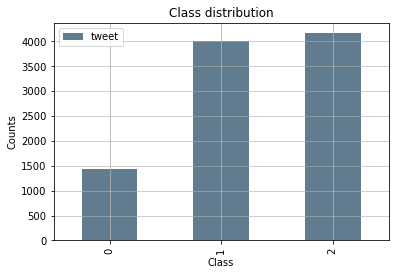

In [7]:
plot_1 = df_2[['class', 'tweet']].groupby('class').count()

plot_1.plot(kind='bar', grid = True,
                   color='#607c8e')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

### Разделение на тренировочные и тестовые данные - 80 и 20 %

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_2['tweet'], df_2['class'], test_size = 0.2)

## Первый способ - CountVectorizer('word', ngram = 1-1) + LogisticRegression

In [29]:
vec = CountVectorizer(ngram_range=(1, 1))
vec.fit(df_2['tweet'])
bow = vec.transform(X_train)

In [30]:
clf = LogisticRegression(random_state=42, solver='liblinear', class_weight = 'balanced')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       247
           1       0.87      0.88      0.88       816
           2       0.96      0.90      0.92       856

    accuracy                           0.86      1919
   macro avg       0.81      0.82      0.81      1919
weighted avg       0.87      0.86      0.87      1919



## Второй способ - TfidfVectorizer + LogisticRegression

In [69]:
pipe = Pipeline([
                ('tf-idf', TfidfVectorizer()),
                ('LogReg', LogisticRegression(random_state=42, 
                                              solver='liblinear', 
                                              class_weight = 'balanced'))
                ])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       253
           1       0.83      0.90      0.87       724
           2       0.97      0.88      0.92       942

    accuracy                           0.86      1919
   macro avg       0.81      0.82      0.81      1919
weighted avg       0.87      0.86      0.86      1919



## Третий способ - CountVectorizer(char, ngram = 1-7) + LogisticRegression

In [70]:
pipe3 = Pipeline([
                ('CountVectChar', CountVectorizer(analyzer='char', ngram_range=(1, 7))),
                ('LogReg', LogisticRegression(random_state=42, solver='liblinear',
                                              class_weight = 'balanced')) 
                 ])
pipe3.fit(X_train, y_train)
y_pred3 = pipe3.predict(X_test)
print(classification_report(y_pred3, y_test))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       265
           1       0.82      0.87      0.85       743
           2       0.96      0.90      0.93       911

    accuracy                           0.85      1919
   macro avg       0.80      0.80      0.80      1919
weighted avg       0.86      0.85      0.85      1919



## Четвёртый способ - CountVectorizer(char, ngram = 1-9) + LogisticRegression

In [71]:
pipe4 = Pipeline([
                ('CountVectChar', CountVectorizer(analyzer='char', ngram_range=(1, 9))),
                ('LogReg', LogisticRegression(random_state=42, solver='liblinear', 
                                              class_weight = 'balanced')) 
                 ])
pipe4.fit(X_train, y_train)
y_pred4 = pipe4.predict(X_test)
print(classification_report(y_pred4, y_test))

              precision    recall  f1-score   support

           0       0.61      0.66      0.63       256
           1       0.83      0.87      0.85       750
           2       0.96      0.90      0.93       913

    accuracy                           0.86      1919
   macro avg       0.80      0.81      0.80      1919
weighted avg       0.86      0.86      0.86      1919



## Пятый способ - CountVectorizer('word',ngram = 1-1) + XGBClassifier

In [84]:
pipe5 = Pipeline([
                ('CountVectChar', CountVectorizer(tokenizer=word_tokenize, 
                                                  ngram_range=(1, 1))),
                ('XGB', XGBClassifier(objective = 'multi:softprob' , 
                                      use_label_encoder=False, 
                                      eval_metric='mlogloss')) 
                 ])
pipe5.fit(X_train, y_train)
y_pred5 = pipe5.predict(X_test)
print(classification_report(y_pred5, y_test))

              precision    recall  f1-score   support

           0       0.57      0.74      0.64       210
           1       0.87      0.88      0.87       785
           2       0.97      0.90      0.93       924

    accuracy                           0.87      1919
   macro avg       0.80      0.84      0.82      1919
weighted avg       0.89      0.87      0.88      1919



## Шестой способ - TfidfVectorizer  + XGBClassifier

In [89]:
pipe6 = Pipeline([
                ('tf-idf', TfidfVectorizer()),
                ('XGB', XGBClassifier(booster='gbtree', objective = 'multi:softprob' , 
                                      use_label_encoder=False,eval_metric='mlogloss')) 
                 ])
pipe6.fit(X_train, y_train)
y_pred6 = pipe6.predict(X_test)
print(classification_report(y_pred6, y_test))

              precision    recall  f1-score   support

           0       0.57      0.71      0.63       222
           1       0.87      0.88      0.87       781
           2       0.96      0.90      0.93       916

    accuracy                           0.87      1919
   macro avg       0.80      0.83      0.81      1919
weighted avg       0.88      0.87      0.87      1919



# +

## Седьмой способ - CountVectorizer('word', ngram = 1-1) + CatBoostClassifier

In [12]:
pipe7 = Pipeline([
                ('CountVectChar', CountVectorizer(ngram_range=(1, 1))),
                ('CBC', CatBoostClassifier(learning_rate=0.6, depth=4, 
                                           loss_function='MultiClass')) 
                 ])
pipe7.fit(X_train, y_train)
y_pred7 = pipe7.predict(X_test)
print(classification_report(y_pred7, y_test))

0:	learn: 0.6952236	total: 37.3ms	remaining: 37.3s
1:	learn: 0.6271671	total: 60.4ms	remaining: 30.2s
2:	learn: 0.5862283	total: 83.9ms	remaining: 27.9s
3:	learn: 0.5593611	total: 108ms	remaining: 26.8s
4:	learn: 0.5371735	total: 131ms	remaining: 26s
5:	learn: 0.5276895	total: 154ms	remaining: 25.5s
6:	learn: 0.5159224	total: 175ms	remaining: 24.9s
7:	learn: 0.5056505	total: 197ms	remaining: 24.4s
8:	learn: 0.4976893	total: 218ms	remaining: 24s
9:	learn: 0.4871658	total: 241ms	remaining: 23.9s
10:	learn: 0.4835503	total: 265ms	remaining: 23.8s
11:	learn: 0.4767522	total: 286ms	remaining: 23.6s
12:	learn: 0.4737513	total: 308ms	remaining: 23.4s
13:	learn: 0.4686236	total: 330ms	remaining: 23.2s
14:	learn: 0.4658155	total: 352ms	remaining: 23.1s
15:	learn: 0.4631738	total: 375ms	remaining: 23.1s
16:	learn: 0.4527748	total: 398ms	remaining: 23s
17:	learn: 0.4515922	total: 420ms	remaining: 22.9s
18:	learn: 0.4466557	total: 442ms	remaining: 22.8s
19:	learn: 0.4458000	total: 467ms	remaining:

161:	learn: 0.3797960	total: 3.67s	remaining: 19s
162:	learn: 0.3796458	total: 3.69s	remaining: 18.9s
163:	learn: 0.3794909	total: 3.71s	remaining: 18.9s
164:	learn: 0.3793526	total: 3.73s	remaining: 18.9s
165:	learn: 0.3792066	total: 3.76s	remaining: 18.9s
166:	learn: 0.3789706	total: 3.78s	remaining: 18.9s
167:	learn: 0.3788124	total: 3.8s	remaining: 18.8s
168:	learn: 0.3785898	total: 3.83s	remaining: 18.8s
169:	learn: 0.3783724	total: 3.85s	remaining: 18.8s
170:	learn: 0.3781150	total: 3.87s	remaining: 18.8s
171:	learn: 0.3779205	total: 3.9s	remaining: 18.8s
172:	learn: 0.3777460	total: 3.92s	remaining: 18.7s
173:	learn: 0.3775924	total: 3.94s	remaining: 18.7s
174:	learn: 0.3774592	total: 3.97s	remaining: 18.7s
175:	learn: 0.3773348	total: 3.99s	remaining: 18.7s
176:	learn: 0.3766897	total: 4.01s	remaining: 18.7s
177:	learn: 0.3739858	total: 4.03s	remaining: 18.6s
178:	learn: 0.3737943	total: 4.05s	remaining: 18.6s
179:	learn: 0.3736629	total: 4.08s	remaining: 18.6s
180:	learn: 0.37

326:	learn: 0.3478169	total: 7.42s	remaining: 15.3s
327:	learn: 0.3476511	total: 7.45s	remaining: 15.3s
328:	learn: 0.3472225	total: 7.47s	remaining: 15.2s
329:	learn: 0.3470226	total: 7.49s	remaining: 15.2s
330:	learn: 0.3469343	total: 7.51s	remaining: 15.2s
331:	learn: 0.3465588	total: 7.54s	remaining: 15.2s
332:	learn: 0.3464886	total: 7.56s	remaining: 15.1s
333:	learn: 0.3463471	total: 7.58s	remaining: 15.1s
334:	learn: 0.3461650	total: 7.6s	remaining: 15.1s
335:	learn: 0.3455649	total: 7.62s	remaining: 15.1s
336:	learn: 0.3453825	total: 7.64s	remaining: 15s
337:	learn: 0.3450731	total: 7.66s	remaining: 15s
338:	learn: 0.3442327	total: 7.68s	remaining: 15s
339:	learn: 0.3441335	total: 7.71s	remaining: 15s
340:	learn: 0.3439769	total: 7.73s	remaining: 14.9s
341:	learn: 0.3434356	total: 7.75s	remaining: 14.9s
342:	learn: 0.3432533	total: 7.77s	remaining: 14.9s
343:	learn: 0.3424404	total: 7.79s	remaining: 14.9s
344:	learn: 0.3421892	total: 7.81s	remaining: 14.8s
345:	learn: 0.3420770

493:	learn: 0.3143628	total: 11.3s	remaining: 11.6s
494:	learn: 0.3142647	total: 11.3s	remaining: 11.6s
495:	learn: 0.3141595	total: 11.3s	remaining: 11.5s
496:	learn: 0.3140261	total: 11.4s	remaining: 11.5s
497:	learn: 0.3139042	total: 11.4s	remaining: 11.5s
498:	learn: 0.3138231	total: 11.4s	remaining: 11.5s
499:	learn: 0.3137275	total: 11.5s	remaining: 11.5s
500:	learn: 0.3136022	total: 11.5s	remaining: 11.4s
501:	learn: 0.3135126	total: 11.5s	remaining: 11.4s
502:	learn: 0.3134114	total: 11.5s	remaining: 11.4s
503:	learn: 0.3133045	total: 11.6s	remaining: 11.4s
504:	learn: 0.3132101	total: 11.6s	remaining: 11.4s
505:	learn: 0.3131296	total: 11.6s	remaining: 11.3s
506:	learn: 0.3127452	total: 11.6s	remaining: 11.3s
507:	learn: 0.3126525	total: 11.7s	remaining: 11.3s
508:	learn: 0.3120757	total: 11.7s	remaining: 11.3s
509:	learn: 0.3119717	total: 11.7s	remaining: 11.3s
510:	learn: 0.3118755	total: 11.7s	remaining: 11.2s
511:	learn: 0.3117086	total: 11.8s	remaining: 11.2s
512:	learn: 

652:	learn: 0.2863095	total: 15.4s	remaining: 8.2s
653:	learn: 0.2858901	total: 15.5s	remaining: 8.18s
654:	learn: 0.2857277	total: 15.5s	remaining: 8.15s
655:	learn: 0.2856513	total: 15.5s	remaining: 8.13s
656:	learn: 0.2855652	total: 15.5s	remaining: 8.1s
657:	learn: 0.2854965	total: 15.5s	remaining: 8.08s
658:	learn: 0.2854210	total: 15.6s	remaining: 8.06s
659:	learn: 0.2853095	total: 15.6s	remaining: 8.03s
660:	learn: 0.2852148	total: 15.6s	remaining: 8.01s
661:	learn: 0.2850309	total: 15.6s	remaining: 7.98s
662:	learn: 0.2848955	total: 15.7s	remaining: 7.96s
663:	learn: 0.2846677	total: 15.7s	remaining: 7.94s
664:	learn: 0.2845288	total: 15.7s	remaining: 7.91s
665:	learn: 0.2842095	total: 15.7s	remaining: 7.89s
666:	learn: 0.2841341	total: 15.8s	remaining: 7.87s
667:	learn: 0.2840439	total: 15.8s	remaining: 7.84s
668:	learn: 0.2838856	total: 15.8s	remaining: 7.82s
669:	learn: 0.2837866	total: 15.8s	remaining: 7.79s
670:	learn: 0.2827838	total: 15.8s	remaining: 7.77s
671:	learn: 0.

815:	learn: 0.2654830	total: 19.3s	remaining: 4.35s
816:	learn: 0.2652014	total: 19.3s	remaining: 4.32s
817:	learn: 0.2650019	total: 19.3s	remaining: 4.3s
818:	learn: 0.2648720	total: 19.3s	remaining: 4.28s
819:	learn: 0.2647675	total: 19.4s	remaining: 4.25s
820:	learn: 0.2646966	total: 19.4s	remaining: 4.23s
821:	learn: 0.2646398	total: 19.4s	remaining: 4.21s
822:	learn: 0.2645637	total: 19.4s	remaining: 4.18s
823:	learn: 0.2643016	total: 19.5s	remaining: 4.16s
824:	learn: 0.2642328	total: 19.5s	remaining: 4.13s
825:	learn: 0.2641861	total: 19.5s	remaining: 4.11s
826:	learn: 0.2641194	total: 19.5s	remaining: 4.09s
827:	learn: 0.2640285	total: 19.6s	remaining: 4.06s
828:	learn: 0.2639574	total: 19.6s	remaining: 4.04s
829:	learn: 0.2638698	total: 19.6s	remaining: 4.01s
830:	learn: 0.2637748	total: 19.6s	remaining: 3.99s
831:	learn: 0.2637190	total: 19.7s	remaining: 3.97s
832:	learn: 0.2636584	total: 19.7s	remaining: 3.94s
833:	learn: 0.2635777	total: 19.7s	remaining: 3.92s
834:	learn: 0

974:	learn: 0.2450049	total: 23.1s	remaining: 593ms
975:	learn: 0.2448989	total: 23.1s	remaining: 569ms
976:	learn: 0.2448425	total: 23.2s	remaining: 545ms
977:	learn: 0.2446933	total: 23.2s	remaining: 522ms
978:	learn: 0.2446259	total: 23.2s	remaining: 498ms
979:	learn: 0.2445065	total: 23.2s	remaining: 474ms
980:	learn: 0.2444301	total: 23.3s	remaining: 450ms
981:	learn: 0.2443713	total: 23.3s	remaining: 427ms
982:	learn: 0.2443108	total: 23.3s	remaining: 403ms
983:	learn: 0.2442570	total: 23.3s	remaining: 379ms
984:	learn: 0.2441969	total: 23.4s	remaining: 356ms
985:	learn: 0.2441542	total: 23.4s	remaining: 332ms
986:	learn: 0.2440563	total: 23.4s	remaining: 308ms
987:	learn: 0.2440000	total: 23.4s	remaining: 285ms
988:	learn: 0.2439256	total: 23.5s	remaining: 261ms
989:	learn: 0.2437902	total: 23.5s	remaining: 237ms
990:	learn: 0.2435149	total: 23.5s	remaining: 213ms
991:	learn: 0.2432741	total: 23.5s	remaining: 190ms
992:	learn: 0.2431949	total: 23.6s	remaining: 166ms
993:	learn: 

## Восьмой способ - TfidfVectorizer  + CatBoostClassifier

In [16]:
pipe8 = Pipeline([
                ('tf-idf', TfidfVectorizer(tokenizer=word_tokenize)),
                ('CBC', CatBoostClassifier(learning_rate=0.6, depth=4, 
                                           loss_function='MultiClass')) 
                 ])
pipe8.fit(X_train, y_train)
y_pred8 = pipe8.predict(X_test)
print(classification_report(y_pred8, y_test))

0:	learn: 0.7462918	total: 51.2ms	remaining: 51.2s
1:	learn: 0.6487639	total: 88.5ms	remaining: 44.2s
2:	learn: 0.6007955	total: 124ms	remaining: 41.2s
3:	learn: 0.5796553	total: 159ms	remaining: 39.7s
4:	learn: 0.5571901	total: 195ms	remaining: 38.8s
5:	learn: 0.5420226	total: 230ms	remaining: 38.1s
6:	learn: 0.5232819	total: 266ms	remaining: 37.7s
7:	learn: 0.5167080	total: 304ms	remaining: 37.7s
8:	learn: 0.5047979	total: 340ms	remaining: 37.4s
9:	learn: 0.5000584	total: 377ms	remaining: 37.3s
10:	learn: 0.4940977	total: 412ms	remaining: 37.1s
11:	learn: 0.4874800	total: 448ms	remaining: 36.9s
12:	learn: 0.4844121	total: 487ms	remaining: 37s
13:	learn: 0.4768626	total: 523ms	remaining: 36.9s
14:	learn: 0.4745415	total: 559ms	remaining: 36.7s
15:	learn: 0.4700309	total: 595ms	remaining: 36.6s
16:	learn: 0.4666069	total: 631ms	remaining: 36.5s
17:	learn: 0.4617081	total: 666ms	remaining: 36.4s
18:	learn: 0.4550673	total: 705ms	remaining: 36.4s
19:	learn: 0.4544401	total: 740ms	remaini

163:	learn: 0.3709364	total: 5.92s	remaining: 30.2s
164:	learn: 0.3707259	total: 5.95s	remaining: 30.1s
165:	learn: 0.3705817	total: 5.99s	remaining: 30.1s
166:	learn: 0.3700459	total: 6.02s	remaining: 30s
167:	learn: 0.3698954	total: 6.06s	remaining: 30s
168:	learn: 0.3697062	total: 6.1s	remaining: 30s
169:	learn: 0.3694004	total: 6.13s	remaining: 29.9s
170:	learn: 0.3690001	total: 6.17s	remaining: 29.9s
171:	learn: 0.3688596	total: 6.2s	remaining: 29.9s
172:	learn: 0.3687219	total: 6.24s	remaining: 29.8s
173:	learn: 0.3654720	total: 6.27s	remaining: 29.8s
174:	learn: 0.3652716	total: 6.31s	remaining: 29.7s
175:	learn: 0.3650868	total: 6.34s	remaining: 29.7s
176:	learn: 0.3648875	total: 6.38s	remaining: 29.7s
177:	learn: 0.3644542	total: 6.42s	remaining: 29.6s
178:	learn: 0.3626180	total: 6.45s	remaining: 29.6s
179:	learn: 0.3624098	total: 6.49s	remaining: 29.5s
180:	learn: 0.3621276	total: 6.52s	remaining: 29.5s
181:	learn: 0.3619852	total: 6.55s	remaining: 29.5s
182:	learn: 0.361766

325:	learn: 0.3313905	total: 11.6s	remaining: 24s
326:	learn: 0.3312610	total: 11.6s	remaining: 23.9s
327:	learn: 0.3311338	total: 11.7s	remaining: 23.9s
328:	learn: 0.3307360	total: 11.7s	remaining: 23.9s
329:	learn: 0.3306010	total: 11.7s	remaining: 23.8s
330:	learn: 0.3303891	total: 11.8s	remaining: 23.8s
331:	learn: 0.3302154	total: 11.8s	remaining: 23.7s
332:	learn: 0.3301066	total: 11.8s	remaining: 23.7s
333:	learn: 0.3299370	total: 11.9s	remaining: 23.7s
334:	learn: 0.3297101	total: 11.9s	remaining: 23.6s
335:	learn: 0.3295688	total: 11.9s	remaining: 23.6s
336:	learn: 0.3294097	total: 12s	remaining: 23.6s
337:	learn: 0.3291389	total: 12s	remaining: 23.5s
338:	learn: 0.3290156	total: 12s	remaining: 23.5s
339:	learn: 0.3288439	total: 12.1s	remaining: 23.4s
340:	learn: 0.3287360	total: 12.1s	remaining: 23.4s
341:	learn: 0.3285496	total: 12.1s	remaining: 23.4s
342:	learn: 0.3282455	total: 12.2s	remaining: 23.3s
343:	learn: 0.3281063	total: 12.2s	remaining: 23.3s
344:	learn: 0.327960

485:	learn: 0.3022979	total: 17s	remaining: 18s
486:	learn: 0.3021503	total: 17s	remaining: 17.9s
487:	learn: 0.3020648	total: 17s	remaining: 17.9s
488:	learn: 0.3019122	total: 17.1s	remaining: 17.8s
489:	learn: 0.3016957	total: 17.1s	remaining: 17.8s
490:	learn: 0.3015975	total: 17.1s	remaining: 17.8s
491:	learn: 0.3014624	total: 17.2s	remaining: 17.7s
492:	learn: 0.3012916	total: 17.2s	remaining: 17.7s
493:	learn: 0.2996661	total: 17.2s	remaining: 17.7s
494:	learn: 0.2995195	total: 17.3s	remaining: 17.6s
495:	learn: 0.2993058	total: 17.3s	remaining: 17.6s
496:	learn: 0.2990932	total: 17.3s	remaining: 17.5s
497:	learn: 0.2989364	total: 17.4s	remaining: 17.5s
498:	learn: 0.2987806	total: 17.4s	remaining: 17.5s
499:	learn: 0.2980999	total: 17.4s	remaining: 17.4s
500:	learn: 0.2979878	total: 17.5s	remaining: 17.4s
501:	learn: 0.2978664	total: 17.5s	remaining: 17.4s
502:	learn: 0.2977726	total: 17.5s	remaining: 17.3s
503:	learn: 0.2976715	total: 17.6s	remaining: 17.3s
504:	learn: 0.297220

645:	learn: 0.2742801	total: 22.3s	remaining: 12.2s
646:	learn: 0.2741158	total: 22.3s	remaining: 12.2s
647:	learn: 0.2740299	total: 22.4s	remaining: 12.1s
648:	learn: 0.2739275	total: 22.4s	remaining: 12.1s
649:	learn: 0.2738405	total: 22.4s	remaining: 12.1s
650:	learn: 0.2737437	total: 22.5s	remaining: 12s
651:	learn: 0.2735934	total: 22.5s	remaining: 12s
652:	learn: 0.2735060	total: 22.5s	remaining: 12s
653:	learn: 0.2729404	total: 22.6s	remaining: 11.9s
654:	learn: 0.2728456	total: 22.6s	remaining: 11.9s
655:	learn: 0.2727465	total: 22.6s	remaining: 11.9s
656:	learn: 0.2725584	total: 22.6s	remaining: 11.8s
657:	learn: 0.2724772	total: 22.7s	remaining: 11.8s
658:	learn: 0.2723863	total: 22.7s	remaining: 11.8s
659:	learn: 0.2723046	total: 22.7s	remaining: 11.7s
660:	learn: 0.2722019	total: 22.8s	remaining: 11.7s
661:	learn: 0.2719597	total: 22.8s	remaining: 11.6s
662:	learn: 0.2718580	total: 22.8s	remaining: 11.6s
663:	learn: 0.2717215	total: 22.9s	remaining: 11.6s
664:	learn: 0.2715

810:	learn: 0.2505735	total: 28.2s	remaining: 6.58s
811:	learn: 0.2504690	total: 28.3s	remaining: 6.54s
812:	learn: 0.2503844	total: 28.3s	remaining: 6.51s
813:	learn: 0.2498620	total: 28.3s	remaining: 6.47s
814:	learn: 0.2497705	total: 28.4s	remaining: 6.44s
815:	learn: 0.2496960	total: 28.4s	remaining: 6.4s
816:	learn: 0.2494570	total: 28.4s	remaining: 6.37s
817:	learn: 0.2492950	total: 28.5s	remaining: 6.33s
818:	learn: 0.2491975	total: 28.5s	remaining: 6.29s
819:	learn: 0.2491038	total: 28.5s	remaining: 6.26s
820:	learn: 0.2490334	total: 28.6s	remaining: 6.22s
821:	learn: 0.2489406	total: 28.6s	remaining: 6.19s
822:	learn: 0.2488148	total: 28.6s	remaining: 6.16s
823:	learn: 0.2487060	total: 28.7s	remaining: 6.12s
824:	learn: 0.2485593	total: 28.7s	remaining: 6.08s
825:	learn: 0.2484868	total: 28.7s	remaining: 6.05s
826:	learn: 0.2484117	total: 28.8s	remaining: 6.01s
827:	learn: 0.2483222	total: 28.8s	remaining: 5.98s
828:	learn: 0.2482421	total: 28.8s	remaining: 5.94s
829:	learn: 0

971:	learn: 0.2306961	total: 33.6s	remaining: 967ms
972:	learn: 0.2306097	total: 33.6s	remaining: 932ms
973:	learn: 0.2305420	total: 33.6s	remaining: 898ms
974:	learn: 0.2304775	total: 33.7s	remaining: 863ms
975:	learn: 0.2304061	total: 33.7s	remaining: 828ms
976:	learn: 0.2301550	total: 33.7s	remaining: 794ms
977:	learn: 0.2300815	total: 33.8s	remaining: 759ms
978:	learn: 0.2299790	total: 33.8s	remaining: 725ms
979:	learn: 0.2298918	total: 33.8s	remaining: 690ms
980:	learn: 0.2298340	total: 33.9s	remaining: 656ms
981:	learn: 0.2297545	total: 33.9s	remaining: 621ms
982:	learn: 0.2296565	total: 33.9s	remaining: 587ms
983:	learn: 0.2295476	total: 34s	remaining: 552ms
984:	learn: 0.2293984	total: 34s	remaining: 518ms
985:	learn: 0.2293145	total: 34s	remaining: 483ms
986:	learn: 0.2292381	total: 34.1s	remaining: 449ms
987:	learn: 0.2291641	total: 34.1s	remaining: 414ms
988:	learn: 0.2290791	total: 34.1s	remaining: 380ms
989:	learn: 0.2290120	total: 34.2s	remaining: 345ms
990:	learn: 0.2289

# Девятый способ с LightGBM

In [8]:
from lightgbm import LGBMClassifier

In [49]:
pipe0 = Pipeline([
                ('tf-idf', TfidfVectorizer(tokenizer=word_tokenize)),
                ('LGMClass', LGBMClassifier()) 
                 ])
pipe0.fit(X_train, y_train)
y_pred0 = pipe0.predict(X_test)
print(classification_report(y_pred0, y_test))

              precision    recall  f1-score   support

           0       0.49      0.72      0.58       191
           1       0.90      0.87      0.88       868
           2       0.95      0.89      0.92       860

    accuracy                           0.86      1919
   macro avg       0.78      0.83      0.80      1919
weighted avg       0.88      0.86      0.87      1919



## Десятый способ - LightGBM + SMOTE

In [9]:
vec_10_1 = TfidfVectorizer()
vec_10_1.fit(df_2['tweet'])
bow_10_1 = vec_10_1.transform(X_train)

C:\conda2\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [18]:
sm_1 = SMOTE (#sampling_strategy = 0.9,
        random_state=0,
        k_neighbors=25)
X_train_res_1, y_train_res_1 = sm_1.fit_resample(bow_10_1, y_train)

In [19]:
pipe0_1 = LGBMClassifier() 
               
pipe0_1.fit(X_train_res_1, y_train_res_1)
y_pred0_1 = pipe0_1.predict(vec_10_1.transform(X_test))
print(classification_report(y_pred0_1, y_test))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63       276
           1       0.84      0.87      0.85       758
           2       0.96      0.91      0.94       885

    accuracy                           0.86      1919
   macro avg       0.80      0.81      0.81      1919
weighted avg       0.86      0.86      0.86      1919



## Одинадцатый способ - tf.keras Tokenizer + LSTM + Adam 

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [35]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [36]:
model_9 = Sequential()
model_9.add(Embedding(max_words, 100, input_length=max_len))
model_9.add(SpatialDropout1D(0.2))
model_9.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_9.add(Dense(1, activation='sigmoid'))
model_9.summary()
model_9.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

2022-03-16 19:27:20.235505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 19:27:20.237251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 19:27:20.238218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 19:27:20.239578: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5,080,503
Trainable params: 5,080,503
Non-trainable params: 0
_________________________________________________________________


In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

stop = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=3
)

checkpoint = ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [38]:
history = model_9.fit(sequences_matrix, y_train,batch_size=1024, epochs=10,
          validation_split=0.2, callbacks=[stop, checkpoint])

2022-03-16 19:27:30.512399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
16/16 [==============================] - 25s 1s/step - loss: 0.0000e+00 - accuracy: 0.7346 - val_loss: 0.0000e+00 - val_accuracy: 0.7736
Epoch 2/10
16/16 [==============================] - 22s 1s/step - loss: 0.0000e+00 - accuracy: 0.7754 - val_loss: 0.0000e+00 - val_accuracy: 0.7736
Epoch 3/10
16/16 [==============================] - 22s 1s/step - loss: 0.0000e+00 - accuracy: 0.7754 - val_loss: 0.0000e+00 - val_accuracy: 0.7736
Epoch 4/10
16/16 [==============================] - 22s 1s/step - loss: 0.0000e+00 - accuracy: 0.7754 - val_loss: 0.0000e+00 - val_accuracy: 0.7736


In [39]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [40]:
accr = model_9.evaluate(test_sequences_matrix, y_test)

155/155 [==============================] - 11s 72ms/step - loss: 0.0000e+00 - accuracy: 0.7714


In [41]:
# не работает
# from sklearn.metrics import accuracy_score
# try:
#     print(classification_report(pred_9, y_test))
# except:
#     print(accuracy_score(pred_9, y_test))
# finally:
#     continue

## Двенадцатый способ - SMOTE + CountVectorizer + SVC

In [12]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(df_2['tweet'], 
                                                                df_2['class'], test_size = 0.2)

In [13]:
vec_10 = CountVectorizer( ngram_range=(1, 1))
vec_10.fit(df_2['tweet'])
bow_10 = vec_10.transform(X_train_10)

## Дисбаланс классов - SMOTE - Synthetic Minority Oversampling Techniques

In [6]:
from imblearn.over_sampling import SMOTE

In [14]:
sm = SMOTE (#sampling_strategy = 0.9,
        random_state=0,
        k_neighbors=4)
X_train_res, y_train_res = sm.fit_resample(bow_10, y_train_10)

In [17]:
print('\t\tДО балансировки \tПОСЛЕ балансировки ')
print('класс 2 : \t{}\t\t\t{}'.format(sum(y_train_10==2), sum(y_train_res==2)))
print('класс 1 : \t{}\t\t\t{}'.format(sum(y_train_10==1), sum(y_train_res==1)))
print('класс 0 : \t{}\t\t\t{}'.format(sum(y_train_10==0), sum(y_train_res==0)))
print('y :\t\t{}\t\t\t{}'.format(y_train_10.shape, y_train_res.shape))
print('X :\t\t{}\t\t{}'.format(bow_10.shape, X_train_res.shape))

		ДО балансировки 	ПОСЛЕ балансировки 
класс 2 : 	3368			3368
класс 1 : 	3159			3368
класс 0 : 	1147			3368
y :		(7674,)			(10104,)
X :		(7674, 11677)		(10104, 11677)


In [10]:
model_10 = SVC()
model_10.fit(X_train_res, y_train_res)
pred_10 = model_10.predict(vec_10.transform(X_test_10))
print(classification_report(pred_10, y_test_10))

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       240
           1       0.82      0.89      0.85       716
           2       0.95      0.84      0.89       963

    accuracy                           0.83      1919
   macro avg       0.76      0.78      0.77      1919
weighted avg       0.85      0.83      0.84      1919



#### для укороченного датасета + SMOTE

In [12]:
clf_00 = LogisticRegression(random_state=42, solver='liblinear')
clf_00.fit(X_train_res, y_train_res)
pred_00 = clf_00.predict(vec_10.transform(X_test_10))
print(classification_report(pred_00, y_test_10))

              precision    recall  f1-score   support

           0       0.62      0.57      0.59       318
           1       0.83      0.89      0.86       731
           2       0.91      0.90      0.91       870

    accuracy                           0.84      1919
   macro avg       0.79      0.78      0.79      1919
weighted avg       0.84      0.84      0.84      1919



#### для длинного датасета + SMOTE

In [8]:
clf_00 = LogisticRegression(random_state=42, solver='liblinear')
clf_00.fit(X_train_res, y_train_res)
pred_00 = clf_00.predict(vec_10.transform(X_test_10))
print(classification_report(pred_00, y_test_10))

              precision    recall  f1-score   support

           0       0.47      0.32      0.38       434
           1       0.89      0.94      0.92      3644
           2       0.87      0.82      0.84       879

    accuracy                           0.86      4957
   macro avg       0.74      0.69      0.71      4957
weighted avg       0.85      0.86      0.86      4957



## Одиннадцатый способ - слои BERT + LogReg

In [36]:
import transformers as ppb

In [37]:
# For DistilBERT:
model_class_11, tokenizer_class_11, pretrained_weights_11 = (ppb.DistilBertModel, 
                                                             ppb.DistilBertTokenizer, 
                                                             'distilbert-base-uncased')

# ## Want BERT instead of distilBERT? Uncomment the following line:
# model_class_11, tokenizer_class_11, pretrained_weights_11 = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer_11 = tokenizer_class_11.from_pretrained(pretrained_weights_11)
model_11 = model_class_11.from_pretrained(pretrained_weights_11)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
def clean_text_for_BERT(text):
    '''Функция на вход получает текст, на выходе выдаёт очищенный текст для BERT'''
    
    text = re.sub("@[\w'._+-:]+", 'USER_NAME_TAG', text) # второй шаг - убираем ники пользователей твитера, т.к. обычно не несут никакой окраски
    text = re.sub('https?://\S+|www\.\S+', 'URL_TAG', text) # третий шаг - убираем ссылки в твитах, т.к. названия ссылок  обычно не влияют на тональность 

    return text

In [41]:
df_11 = df_1.copy()

In [42]:
df_11['tweet'] = df_11['tweet'].apply(clean_text_for_BERT)

In [43]:
#токенизация
tokenized = df_11['tweet'].apply(lambda x: tokenizer_11.encode(x, add_special_tokens=True))

In [44]:
#padding - Выравниваем предложения по длине с помощью нулевых токенов.

# находим самое длинное предложение
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# заполняем обучающие данные, где не хватает длины до максимума -- добавляем нули
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [45]:
np.array(padded).shape

(24783, 479)

In [46]:
padded[0]

array([  101,   999,   999,   999, 19387,  5310,  1035,  2171,  1035,
        6415,  2004,  1037,  2450,  2017,  5807,  1005,  1056, 17612,
        2055,  9344,  2039,  2115,  2160,  1012,  1004, 23713,  1025,
        2004,  1037,  2158,  2017,  2323,  2467,  2202,  1996, 11669,
        2041,  1012,  1012,  1012,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [47]:
#Masking - Теперь создаём отдельную переменную, чтобы сказать берту, что надо игнорировать паддинг при подсчёте attention.
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [48]:
import torch

In [49]:
#Используем BERT-model() прогоняет предложения через BERT
# повысить если Kaggle-Kernel
input_ids = torch.tensor(padded[:200])  
attention_mask = torch.tensor(attention_mask[:200])

with torch.no_grad():
    last_hidden_states = model_11(input_ids, attention_mask=attention_mask)

In [50]:
features = last_hidden_states[0][:,0,:].numpy()

In [51]:
features

array([[-0.01853382, -0.05220667,  0.05905863, ..., -0.12232067,
         0.20900404,  0.4365031 ],
       [-0.27208817,  0.09054741,  0.11396429, ..., -0.15788054,
         0.43918195,  0.4675711 ],
       [ 0.05119757,  0.14024201,  0.0734151 , ..., -0.30908403,
         0.42747226,  0.2912435 ],
       ...,
       [-0.00853779, -0.176043  ,  0.2262561 , ..., -0.29322883,
         0.03703219,  0.20644757],
       [-0.08880064, -0.08202468,  0.00843922, ...,  0.02047456,
         0.4005721 ,  0.127333  ],
       [ 0.14387845, -0.04371598,  0.0332372 , ..., -0.3831732 ,
         0.27007025,  0.3577918 ]], dtype=float32)

In [52]:
features.shape

(200, 768)

In [53]:
labels = df_11['class'][:200]

In [54]:
labels.unique()

array([2, 1, 0], dtype=int64)

<AxesSubplot:>

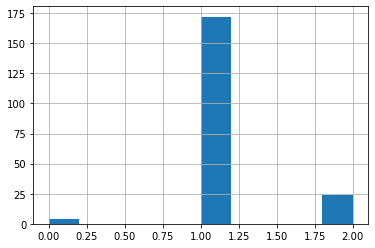

In [55]:
labels.hist()

In [56]:
labels.shape

(200,)

In [57]:
#LogReg на признаках из BERT
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [58]:
lr_clf_11 = LogisticRegression(class_weight = 'balanced')
lr_clf_11.fit(train_features, train_labels)
print(classification_report(lr_clf_11.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.91      0.93      0.92        42
           2       0.57      0.67      0.62         6

    accuracy                           0.86        50
   macro avg       0.49      0.53      0.51        50
weighted avg       0.83      0.86      0.84        50



C:\conda2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\conda2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\conda2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

## Двенадцатый способ - взять с BERTа и обучить SVC

In [60]:
lr_clf_12 = SVC(class_weight = 'balanced')
lr_clf_12.fit(train_features, train_labels)
print(classification_report(lr_clf_12.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.51      1.00      0.68        22
           2       0.86      0.27      0.41        22

    accuracy                           0.56        50
   macro avg       0.46      0.42      0.36        50
weighted avg       0.60      0.56      0.48        50



C:\conda2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\conda2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\conda2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Визуализация метрик основных результативных алгоритмов

In [66]:
Metrics_1 = pd.DataFrame({
                        'TfLr' : [0.65, 0.87, 0.92, 0.86], 
                        'CCat' : [0.64, 0.89, 0.93, 0.88],
                        'TfLgSm' : [0.63, 0.85, 0.94, 0.86],
                        'CLrSm5000' : [0.59, 0.86, 0.91, 0.84],
                        'BERTLr1000' : [0.40, 0.89, 0.63, 0.81],
                        'BERTSvc1000' : [0.47, 0.87, 0.69, 0.78]
                        }, 
                        index = ['0', '1', '2', 'accuracy']
                        )

In [67]:
Metrics_1.head()

,TfLr,CCat,TfLgSm,CLrSm5000,BERTLr1000,BERTSvc1000
0,0.65,0.64,0.63,0.59,0.40,0.47
1,0.87,0.89,0.85,0.86,0.89,0.87
2,0.92,0.93,0.94,0.91,0.63,0.69
accuracy,0.86,0.88,0.86,0.84,0.81,0.78


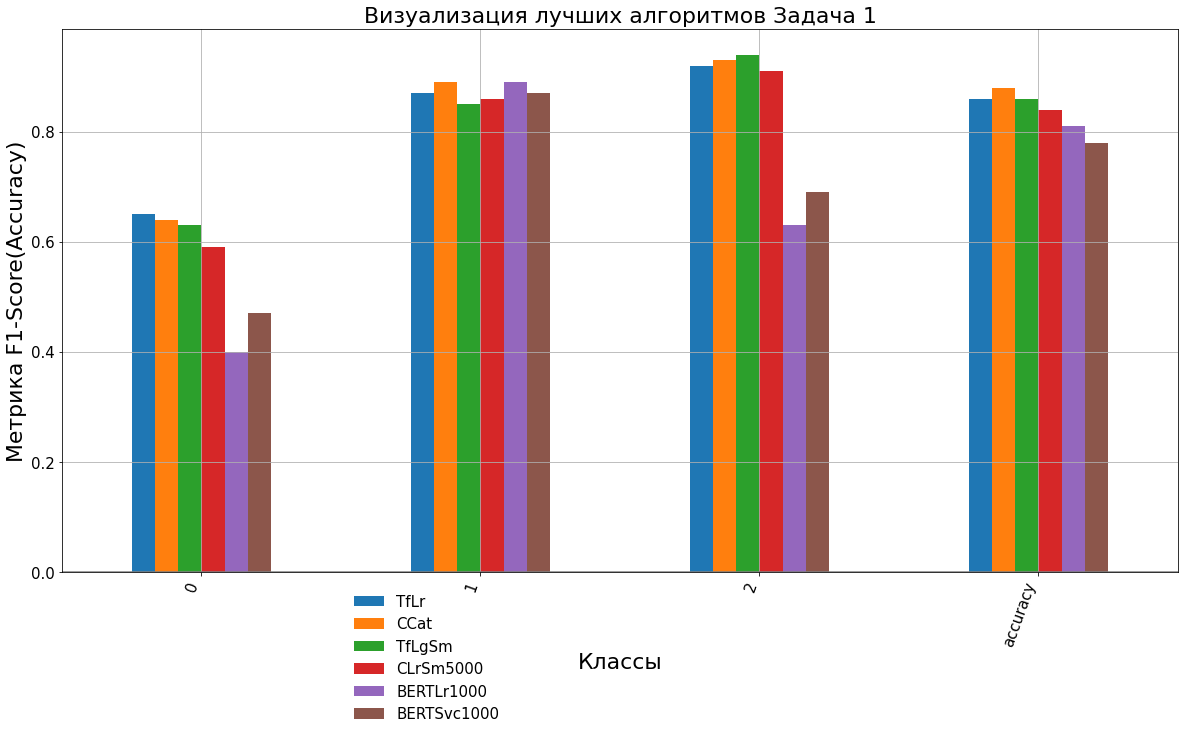

In [68]:
Metrics_1.plot(kind='bar', 
            figsize = (20,10))
plt.grid()
plt.title('Визуализация лучших алгоритмов Задача 1', fontsize=22)
plt.xlabel('Классы', fontsize=22)
plt.ylabel('Метрика F1-Score(Accuracy)', fontsize=22)
plt.gca().set_xticklabels(Metrics_1.index, rotation=70, horizontalalignment= 'right')
plt.tick_params(
    bottom=True,
    left=True,
    labelsize=15
)

plt.axhline(y=0, color='gray')
plt.legend(frameon=False,  bbox_to_anchor=(0.25, -0.3, 0.5, 0.5), prop={'size':15})
plt.show()